In [17]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Define hyperparameters
batch_size = 64 

# Define data transformations
transform = transforms.Compose( 
    [transforms.Resize((64, 64)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 

# Load the data
trainset = torchvision.datasets.ImageFolder(root='/Users/newuser/Projects/robust-algo-trader/cnn/train', transform=transform) 
testset = torchvision.datasets.ImageFolder(root='/Users/newuser/Projects/robust-algo-trader/cnn/test', transform=transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

# classes = ('won', 'loss')

In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path
import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        

for inputs, labels in train_loader:
    break

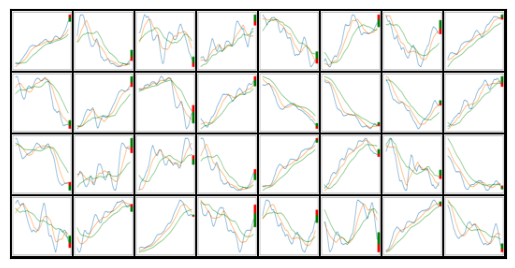

In [19]:
grid = make_grid([torch.squeeze(inputs[x]) for x in range(32)])
show(grid) 

In [20]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

Using mps device


In [21]:

# Define the model
class CNNet(nn.Module):
    def __init__(self):
        super(CNNet, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 16, 3) # Input channels, output channels, kernel size
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2) # Kernel size, stride
        # Dropout layer
        self.dropout = nn.Dropout(0.25)
        # Linear layers
        self.fc1 = nn.Linear(64 * 6 * 6, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1) 
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Apply the convolutional layers with pooling and dropout
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = self.dropout(x)
        # Flatten the output of the last convolutional layer
        x = torch.flatten(x, 1)
        # Apply the linear layers with dropout and sigmoid
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

cnn = CNNet()
cnn.to(device)

criterion = nn.BCELoss()
learning_rate = 0.01
optimizer = optim.Adam(cnn.parameters(), lr=learning_rate)

In [22]:
# Define a function to compute accuracy
def accuracy(outputs, labels):
    predicted = torch.round(outputs)
    correct = (predicted == labels).sum().item()
    return 100 * correct / len(labels)


# Define test function
def test(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss_sum, test_correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            label = y.float().view(-1, 1)
            test_loss_sum += criterion(pred, label).item()
            test_correct += (pred > 0.5).eq(y.view_as(pred)).sum().item()
    print(f"Test Loss: {test_loss_sum / num_batches}")
    print(f"Test Accuracy: {test_correct / size}")


# Define train function
def train(dataloader, model, criterion, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    train_loss_sum, train_correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        label = y.float().view(-1, 1)
        loss = criterion(pred, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_sum += loss.item()
        train_correct += (pred > 0.5).eq(y.view_as(pred)).sum().item()
    print(f"Train Loss: {train_loss_sum / num_batches}")
    print(f"Train Accuracy: {train_correct / size}")
    
epochs = 500_000_000
# epochs = 50
# epochs = 10
for t in range(epochs):
    print("-------------------------------\n",
        f"Epoch {t+1}\n",
        "-------------------------------")
    train(train_loader, cnn, criterion, optimizer)
    test(test_loader, cnn, criterion)
print("Done!")

-------------------------------
 Epoch 1
 -------------------------------
Train Loss: 0.799795389175415
Train Accuracy: 0.5136741973840666
Test Loss: 0.7245039176718097
Test Accuracy: 0.3356094726136859
-------------------------------
 Epoch 2
 -------------------------------
Train Loss: 0.690592476954827
Train Accuracy: 0.5338882282996433
Test Loss: 0.7231346769867656
Test Accuracy: 0.3356094726136859
-------------------------------
 Epoch 3
 -------------------------------
Train Loss: 0.6905576219925513
Train Accuracy: 0.535077288941736
Test Loss: 0.7167949208589358
Test Accuracy: 0.3356094726136859
-------------------------------
 Epoch 4
 -------------------------------
Train Loss: 0.6918901617710407
Train Accuracy: 0.5303210463733651
Test Loss: 0.7210485968634347
Test Accuracy: 0.3356094726136859
-------------------------------
 Epoch 5
 -------------------------------
Train Loss: 0.6913438210120568
Train Accuracy: 0.5326991676575505
Test Loss: 0.7051583617647118
Test Accuracy: 0.

In [ ]:



# Save the model
PATH = './model.pth'
torch.save(model.state_dict(), PATH)

# Load the model
model = Net()
model.load_state_dict(torch.load(PATH))
model.to(device)

# Test the model
y_true = [] # True labels
y_score = [] # Predicted scores
y_pred = [] # Predicted labels
with torch.no_grad(): # No need to track the gradients
    for data in test_loader: # Loop over the batches of data
        # Get the inputs and the labels
        inputs, labels = data
        # Reshape the labels to match the output shape
        labels = labels.view(-1, 1)
        # Move the inputs and the labels to the device
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(inputs)
        # Compute the accuracy
        acc = accuracy(outputs, labels)
        print('Accuracy: %.2f %%' % acc)
        # Append the true labels, predicted scores and predicted labels
        y_true.extend(labels.cpu().numpy())
        y_score.extend(outputs.cpu().numpy())
        y_pred.extend(torch.round(outputs).cpu().numpy())

# Compute the precision, recall and F1 score
precision = accuracy(np.array(y_true), np.array(y_pred))
recall = accuracy(np.array(y_pred), np.array(y_true))
f1_score = 2 * precision * recall / (precision + recall)
print('Precision: %.2f %%' % precision)
print('Recall: %.2f %%' % recall)
print('F1 score: %.2f %%' % f1_score)

# Plot the ROC curve and compute the AUC
fpr, tpr, thresholds = roc_curve(y_true, y_score) # False positive rate, true positive rate, thresholds
roc_auc = auc(fpr, tpr) # Area under the curve
plt.figure() # Create a new figure
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc) # Plot the ROC curve
plt.plot([0, 1], [0, 1], color='navy', linestyle='--') # Plot the random guess line
plt.xlim([0.0, 1.0]) # Set the x-axis limit
plt.ylim([0.0, 1.05]) # Set the y-axis limit
plt.xlabel('False Positive Rate') # Set the x-axis label
plt.ylabel('True Positive Rate') # Set the y-axis label
plt.title('Receiver operating characteristic') # Set the title
# plt.legend(loc